<a href="https://colab.research.google.com/github/nannthd/project_AIEngineer/blob/main/license_plate_EasyOCR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


In [ ]:
!pip install pytube opencv-python-headless

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

#Data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AWtZRbYK04sFZNNZ1t4X")
project = rf.workspace("projectaiengineer").project("license-plates-gpj5f")
version = project.version(2)
dataset = version.download("yolov8")

In [ ]:
%cat {dataset.location}/data.yaml

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
%cat {dataset.location}/data.yaml

# Load a model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load a model
model = YOLO("/content/drive/MyDrive/license plate/best.pt")

In [ ]:
model.names

{0: 'number', 1: 'province'}

In [ ]:
image_test = '/content/-license-plates-2/test/images'

In [ ]:
pred = model.predict(image_test, save=True, save_txt=True)
pred

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = '/content/runs/detect/predict'

# ตรวจสอบว่าไดเรกทอรีนี้มีไฟล์ภาพหรือไม่
if os.path.isdir(directory):
    # หากมีไฟล์ภาพในไดเรกทอรี
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # แสดงภาพทีละภาพ
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        img = mpimg.imread(image_path)

        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')  # ปิดแกน X และ Y
        plt.show()
else:
    print("ไม่พบไดเรกทอรีที่ระบุ")

#EasyOCR

In [ ]:
!pip install ultralytics

In [ ]:
!pip install easyocr

In [ ]:
!pip install opencv-python-headless

## ไม่crop + เพิ่มแสง

In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr
import numpy as np

# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255
        gamma_b = shadow
        image = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)

    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        image = cv2.addWeighted(image, alpha_c, image, 0, gamma_c)

    return image

# Function to denoise image
def denoise_image(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# Function to increase brightness
def increase_brightness(image, value=30):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v += value
    final_hsv = cv2.merge((h, s, v))
    image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return image

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image
input_image_path = '/content/-license-plates-2/test/images/CH1_20150510115910_3-2589_jpg.rf.a958732bf784a6be3d3cfa9810e56b8f.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Step 5: Perform Inference
results = model.predict(image_rgb)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = image_rgb.copy()
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Extract the detected region
        detected_region = image_rgb[y1:y2, x1:x2]

        # Adjust brightness and contrast
        adjusted_region = adjust_brightness_contrast(detected_region, brightness=20, contrast=20)

        # Increase brightness
        brightened_region = increase_brightness(adjusted_region, value=30)

        # Denoise the brightened region
        denoised_region = denoise_image(brightened_region)

        # Resize the denoised region to the same size as the bounding box
        resized_region = cv2.resize(denoised_region, (x2-x1, y2-y1), interpolation=cv2.INTER_AREA)

        # Replace the detected region with the processed region in the output image
        output_image[y1:y2, x1:x2] = resized_region

        # Apply EasyOCR to the resized region
        ocr_result = reader.readtext(resized_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Processed Regions
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)

## crop + เพิ่มแสง

In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
# import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image and Adjust Brightness
input_image_path = '/content/-license-plates-2/test/images/CH1_20150510115910_3-2589_jpg.rf.a958732bf784a6be3d3cfa9810e56b8f.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Adjust brightness
brightness = 45  # Adjust brightness level as needed
image_brightened = cv2.addWeighted(image_rgb, 1.0 + brightness / 100.0, image_rgb, 0, 0)

# Step 5: Perform Inference
results = model.predict(image_brightened)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = image_brightened.copy()  # Use the brightened image for processing
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category
cropped_images = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Draw bounding box
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract the detected region and convert to grayscale
        detected_region = cv2.cvtColor(image_brightened[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        cropped_images.append((class_id, detected_region))

        # Apply EasyOCR to the grayscale region
        ocr_result = reader.readtext(detected_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Bounding Boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Display Cropped Images of Each Class
for idx, (class_id, cropped_image) in enumerate(cropped_images):
    plt.figure(figsize=(5, 5))
    plt.title(f'Class ID: {class_id}')
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Step 10: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)

In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
# import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image and Adjust Brightness
input_image_path = '/content/-license-plates-2/valid/images/CH1_20150510134337_3-6201_jpg.rf.80f5aa1e736df92645bff6abf814eafc.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Adjust brightness
brightness = 45  # Adjust brightness level as needed
image_brightened = cv2.addWeighted(image_rgb, 1.0 + brightness / 100.0, image_rgb, 0, 0)

# Step 5: Perform Inference
results = model.predict(image_brightened)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = image_brightened.copy()  # Use the brightened image for processing
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category
cropped_images = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Draw bounding box
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract the detected region and convert to grayscale
        detected_region = cv2.cvtColor(image_brightened[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        cropped_images.append((class_id, detected_region))

        # Apply EasyOCR to the grayscale region
        ocr_result = reader.readtext(detected_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Bounding Boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Display Cropped Images of Each Class
for idx, (class_id, cropped_image) in enumerate(cropped_images):
    plt.figure(figsize=(5, 5))
    plt.title(f'Class ID: {class_id}')
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Step 10: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)

## crop + ปรับcontrast







0: 640x640 1 number, 1 province, 266.4ms
Speed: 5.7ms preprocess, 266.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


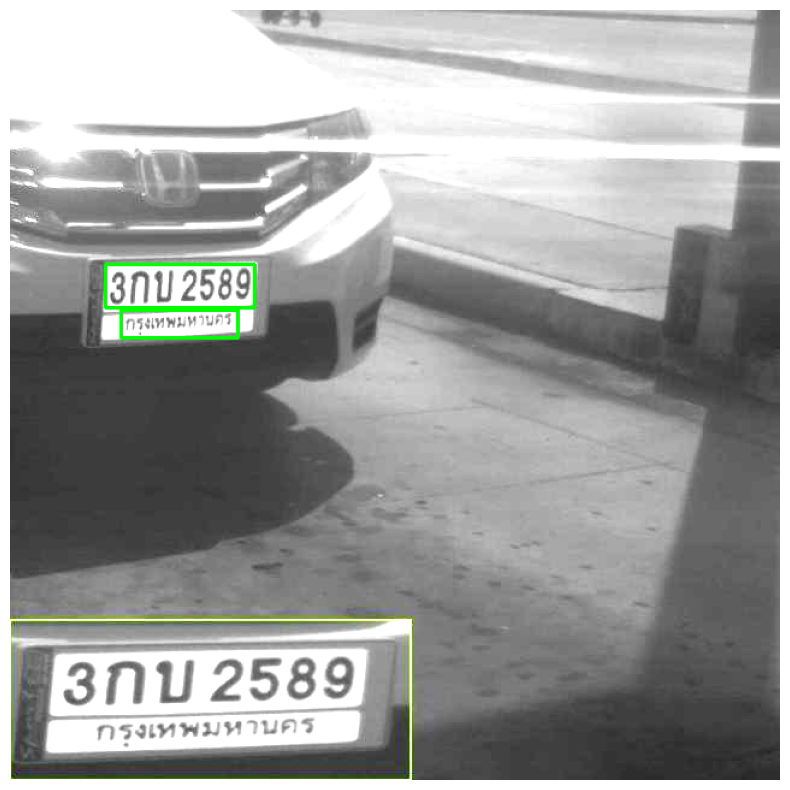

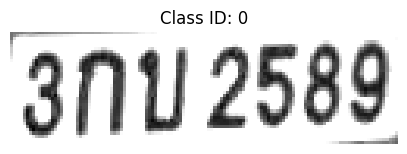

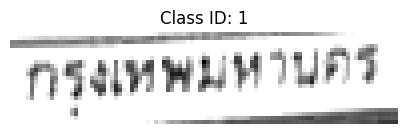

Detected Texts - Number:
3กบ2589

Detected Texts - Province:
กรงเทพมทานคร


In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
# import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image and Adjust Contrast
input_image_path = '/content/-license-plates-2/test/images/CH1_20150510115910_3-2589_jpg.rf.a958732bf784a6be3d3cfa9810e56b8f.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Adjust contrast
alpha = 3  # Contrast control (1.0-3.0)
adjusted_image = cv2.convertScaleAbs(image_rgb, alpha=alpha, beta=0)

# Step 5: Perform Inference
results = model.predict(adjusted_image)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = adjusted_image.copy()  # Use the adjusted image for processing
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category
cropped_images = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Draw bounding box
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract the detected region and convert to grayscale
        detected_region = cv2.cvtColor(adjusted_image[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        cropped_images.append((class_id, detected_region))

        # Apply EasyOCR to the grayscale region
        ocr_result = reader.readtext(detected_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Bounding Boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Display Cropped Images of Each Class
for idx, (class_id, cropped_image) in enumerate(cropped_images):
    plt.figure(figsize=(5, 5))
    plt.title(f'Class ID: {class_id}')
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Step 10: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)

#ภาพที่ใช้ได้

## ภาพที่ 1


0: 640x640 1 number, 1 province, 242.1ms
Speed: 8.5ms preprocess, 242.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


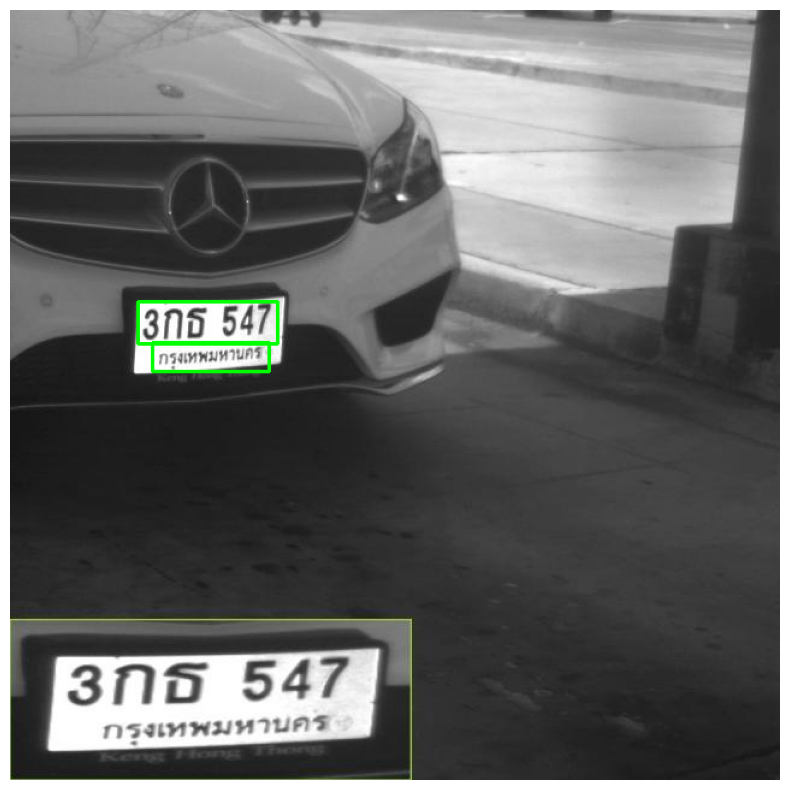

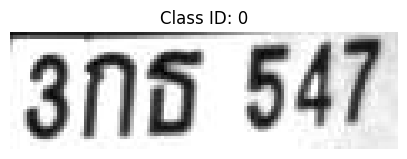

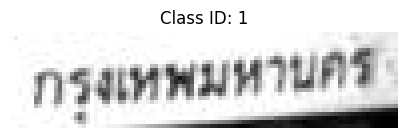

Detected Texts - Number:
3กธ 547

Detected Texts - Province:
กรุงเทพมหานคร


In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr
import numpy as np

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image
input_image_path = '/content/drive/MyDrive/license plate/1.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Step 5: Perform Inference
results = model.predict(image_rgb)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = image_rgb.copy()
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category
cropped_images = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Draw bounding box
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract the detected region and convert to grayscale
        detected_region = cv2.cvtColor(image_rgb[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        cropped_images.append((class_id, detected_region))

        # Apply EasyOCR to the grayscale region
        ocr_result = reader.readtext(detected_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Bounding Boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Display Cropped Images of Each Class
for idx, (class_id, cropped_image) in enumerate(cropped_images):
    plt.figure(figsize=(5, 5))
    plt.title(f'Class ID: {class_id}')
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Step 10: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)

## ภาพที่ 2


0: 640x640 1 number, 1 province, 395.8ms
Speed: 2.8ms preprocess, 395.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


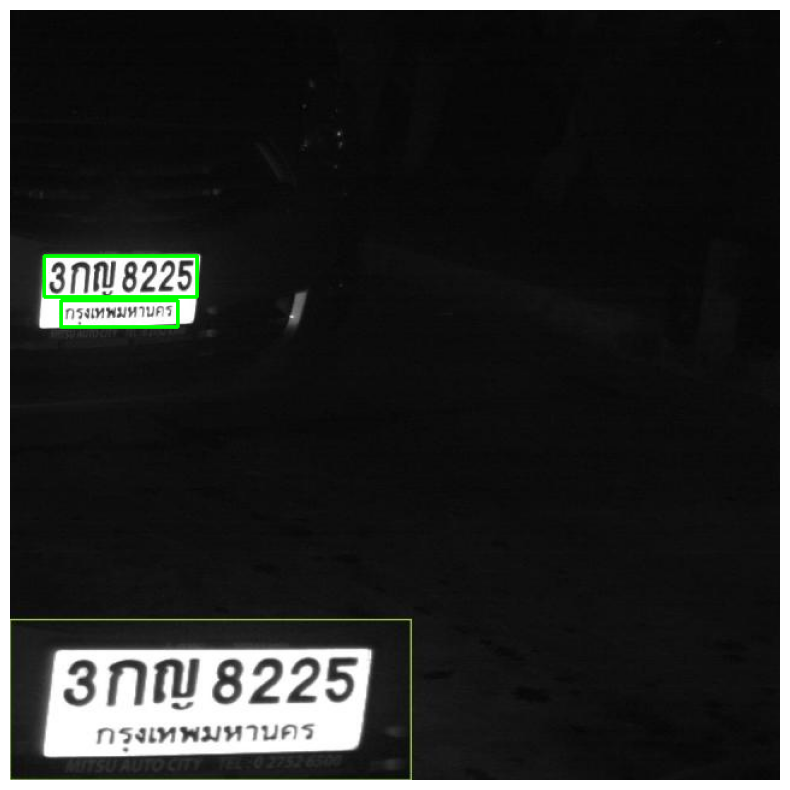

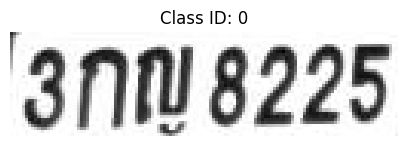

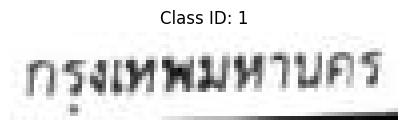

Detected Texts - Number:
3กญ8225

Detected Texts - Province:
กรุงเทพมหานคร


In [ ]:
# Step 1: Install YOLOv8, EasyOCR, and OpenCV
# !pip install ultralytics
# !pip install easyocr
# !pip install opencv-python-headless

# Step 2: Import Required Libraries
import cv2
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import easyocr
import numpy as np

# Step 3: Load the YOLOv8 Model with Custom Weights
model = YOLO('/content/drive/MyDrive/license plate/best.pt')  # Replace with the path to your weights file

# Step 4: Load the Input Image
input_image_path = '/content/drive/MyDrive/license plate/2.jpg'  # Replace with the path to your input image
image = cv2.imread(input_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Step 5: Perform Inference
results = model.predict(image_rgb)

# Step 6: Initialize EasyOCR Reader for Thai Language
reader = easyocr.Reader(['th'])  # Specify 'th' for Thai language

# Step 7: Process Each Detection and Apply EasyOCR
output_image = image_rgb.copy()
detected_texts = {'text_number': [], 'text_province': []}  # Dictionary to store texts by category
cropped_images = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Access the bounding box coordinates
        class_id = int(box.cls)  # Access the class ID

        # Draw bounding box
        cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract the detected region and convert to grayscale
        detected_region = cv2.cvtColor(image_rgb[y1:y2, x1:x2], cv2.COLOR_RGB2GRAY)
        cropped_images.append((class_id, detected_region))

        # Apply EasyOCR to the grayscale region
        ocr_result = reader.readtext(detected_region)

        # Collect OCR result and categorize by class
        for (bbox, text, prob) in ocr_result:
            if class_id == 0:
                detected_texts['text_number'].append(text)
            elif class_id == 1:
                detected_texts['text_province'].append(text)

# Step 8: Display the Output Image with Bounding Boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()

# Step 9: Display Cropped Images of Each Class
for idx, (class_id, cropped_image) in enumerate(cropped_images):
    plt.figure(figsize=(5, 5))
    plt.title(f'Class ID: {class_id}')
    plt.imshow(cropped_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Step 10: Print the OCR Results
print("Detected Texts - Number:")
for text in detected_texts['text_number']:
    print(text)

print("\nDetected Texts - Province:")
for text in detected_texts['text_province']:
    print(text)